<a href="https://colab.research.google.com/github/ojimenel/entregable/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import files

In [ ]:
from keras.preprocessing.image import img_to_array

# Processing Images

In [ ]:
# opens images and resizes them
def load_image(image_path):
  img = Image.open(image_path)
  img = img.resize((512, round(512/img.size[0]*img.size[1])))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img

In [ ]:
# loads images and runs them through vgg19 preprocessing
def process_image(image_path):
  img = load_image(image_path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [ ]:
# deprocess images from vgg19
def deprocess_image(image):
  image = np.squeeze(image, axis = 0)
  mean = [103.939, 116.779, 123.68]
  image[:, :, 0] += 103.939
  image[:, :, 1] += 116.779
  image[:, :, 2] += 123.68
  image = image[:, :, ::-1]

  image = np.clip(image, 0, 255).astype('uint8')
  return image

# Loading Model

In [ ]:
from tensorflow.python.keras import models

In [ ]:
# layers used for feature extraction

s_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

c_layers = ['block5_conv2']

In [ ]:
# create vgg19 model
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  style_layers = [vgg.get_layer(name).output for name in s_layers]
  content_layers = [vgg.get_layer(name).output for name in c_layers]

  model_layers = style_layers + content_layers

  model = models.Model(vgg.input, model_layers)

  return model

# Gram Matrix

In [ ]:
def gram_matrix(tensor):
  channels = int(tensor.shape[-1])
  a = tf.reshape(tensor, [-1, channels])
  gram = tf.matmul(a, a, transpose_a = True)
  return gram

# Extract Feature Representation

In [ ]:
def get_content_features(content, model):
  content_output = model(content)
  content_features = [layer[0] for layer in content_output[len(s_layers):]]
  return content_features

In [ ]:
def get_style_features(style, model):
  style_output = model(style)
  style_features = [layer[0] for layer in style_output[:len(s_layers)]]
  return style_features

# Loss

In [ ]:
def get_style_loss(image, gram_style, style_weight, model):
  style_weights = [0.5, 0.3, 0.1, 0.075, 0.025]

  style_image_features = get_style_features(image, model)

  style_loss = 0

  for i in range(len(style_weights)):
    style_loss += style_weights[i] * tf.reduce_mean(tf.square(gram_matrix(style_image_features[i]) - gram_style[i]))

  return style_loss * style_weight

In [ ]:
def get_content_loss(image, content_features, content_weight, model):
  content_image_features = get_content_features(image, model)

  content_loss = tf.reduce_mean(tf.square(content_image_features[0] - content_features[0]))

  return content_loss * content_weight

# Graidents

In [ ]:
def compute_grad(content_features, style_features, gram_style, image, content_weight, style_weight, model):
  with tf.GradientTape() as tape:
    tape.watch(image)

    style_loss = get_style_loss(image, gram_style, style_weight, model)
    content_loss = get_content_loss(image, content_features, content_weight, model)
    
    loss = style_loss + content_loss

  grad = tape.gradient(loss, image)

  return grad, loss

# Training

In [ ]:
def train(content_path, style_path, steps=1000,content_weight=1e3, style_weight=1e-2):
  model = get_model()
  for layer in model.layers:
    layer.trainable = False
  
  content = process_image(content_path)
  style = process_image(style_path)

  image = process_image(content_path)
  image = tf.Variable(image)

  content_features = get_content_features(content, model)
  style_features = get_style_features(style, model)
  gram_style = [gram_matrix(style_feature) for style_feature in style_features]


  optimizer = tf.keras.optimizers.Adam(learning_rate = 5)

  img = []
  best_loss = float('inf')

  print("Starting...")
  for i in range(steps):
    grad, loss = compute_grad(content_features, style_features, gram_style, image, content_weight, style_weight, model)
    optimizer.apply_gradients([(grad, image)])

    if loss < best_loss:
      best_loss = loss
      best_image = deprocess_image(image.numpy())

    if i % 100 == 0:
      img.append(deprocess_image(image.numpy()))
      print("step#: ", i, "/", steps)
      print("total loss:", loss)
  
  return best_image, img

# Running Everything

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving amber.jpg to amber.jpg
User uploaded file "amber.jpg" with length 108086 bytes


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Verifica si hay conexión creando el archivo foo.txt que despues se puede borrar

with open('/content/drive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/drive/My\ Drive/foo.txt

Hello Google Drive!

In [ ]:
# download images and place them in My Drive
# mount drive under files on the left
content_path = '/content/drive/My Drive/images/content-images/amber.jpg'
style_path = '/content/drive/My Drive/images/style-images/candy.jpg'



In [ ]:
final, imgs = train(content_path, style_path)

Starting...
step#:  0 / 1000
total loss: tf.Tensor(1.4138703e+16, shape=(), dtype=float32)
step#:  100 / 1000
total loss: tf.Tensor(102233480000000.0, shape=(), dtype=float32)
step#:  200 / 1000
total loss: tf.Tensor(29292054000000.0, shape=(), dtype=float32)
step#:  300 / 1000
total loss: tf.Tensor(15337665000000.0, shape=(), dtype=float32)
step#:  400 / 1000
total loss: tf.Tensor(10441554000000.0, shape=(), dtype=float32)
step#:  500 / 1000
total loss: tf.Tensor(7970725000000.0, shape=(), dtype=float32)
step#:  600 / 1000
total loss: tf.Tensor(6477565000000.0, shape=(), dtype=float32)
step#:  700 / 1000
total loss: tf.Tensor(5536052400000.0, shape=(), dtype=float32)
step#:  800 / 1000
total loss: tf.Tensor(4826534500000.0, shape=(), dtype=float32)
step#:  900 / 1000
total loss: tf.Tensor(4593237400000.0, shape=(), dtype=float32)


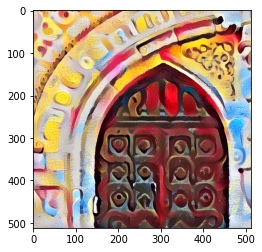

In [ ]:
plt.imshow(final)

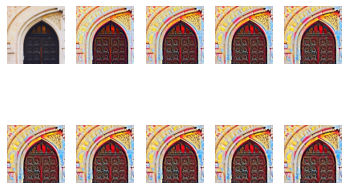

In [ ]:
fig, axs = plt.subplots(int((len(imgs) / 5)), 5)
for ax, image in zip(axs.flatten(), imgs):
  ax.imshow(image)
  ax.axis("off")

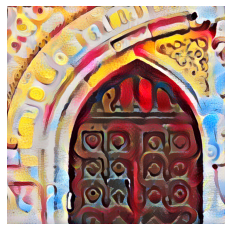

In [ ]:
plt.axis('off')
plt.imshow(final)
plt.savefig('StyleTransfer.png', bbox_inches='tight', pad_inches=0)

In [ ]:
files.download('StyleTransfer.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>